authorship assignment papers:
 - http://publications.idiap.ch/downloads/papers/2020/Fabien_ICON2020_2020.pdf
 - https://link.springer.com/content/pdf/10.1007%2F978-3-540-30115-8_22.pdf  
 
bert multiclass classsification:
 - https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
   - from: https://www.coursera.org/projects/sentiment-analysis-bert

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from toolz import curry

from sklearn.model_selection import train_test_split

seed = 666

### format data

In [2]:
raw = pd.read_parquet('../data/processed/emails.parquet')
df = raw.dropna()

print(raw.shape)
print(df.shape)

(126057, 7)
(125684, 7)


In [3]:
def format_names(x):
    return [y.split('@')[0] for y in x.strip().split(',')]

df = df.assign(recip=df['To'].apply(format_names),
               author=df['From'].apply(lambda x: x.strip().split('@')[0]))
# wish this worked
# df = df.assign(recip, author = map(lambda col: df[col].apply(format_names), ['To', 'From']))

df = df.assign(recip_primary=df['recip'].apply(lambda x: x[0]))
df[['subject', 'body']] = df[['Subject', 'Body']].apply(lambda col: col.str.strip())

In [4]:
X = df[['author', 'recip_primary', 'subject', 'body']].dropna()
X = X.replace('', np.nan).dropna()
X

,author,recip_primary,subject,body
1,ina.rangel,amanda.huble,Headcount,Financial (6)\n West Desk (14)\nMid Market ...
7,phillip.allen,ina.rangel,Re:,"Ina,\n\n Can you pull Tori K.'s and Martin Cui..."
8,phillip.allen,john.lavorato,Re:,resumes of whom?
12,phillip.allen,colleen.sullivan,Re: Transportation Reports,it is ok with me.
13,phillip.allen,rich,Re: Western Gas Market Report -- Draft,"Richard,\n\n Compare your california productio..."
...,...,...,...,...
126052,john.zufferli,kori.loibl,Trade with John Lavorato,This is a trade with OIL-SPEC-HEDGE-NG (John L...
126053,john.zufferli,john.lavorato,Gas Hedges,Some of my position is with the Alberta Term b...
126054,john.zufferli,dawn.doucet,RE: CONFIDENTIAL,2
126055,john.zufferli,jeanie.slone,Calgary Analyst/Associate,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...


In [5]:
X['body'][:10]

1     Financial  (6)\n  West Desk  (14)\nMid Market ...
7     Ina,\n\n Can you pull Tori K.'s and Martin Cui...
8                                      resumes of whom?
12                                    it is ok with me.
13    Richard,\n\n Compare your california productio...
18    Greg,\n\n Got your message.  Good luck on the ...
19                   Why are his requests coming to me?
27    Suzanne,\n\n Can you give me more details or e...
28    Colleen,\n\n Please add Mike Grigsby to the di...
30    Bruce,\n\nCan you stop by and set up my reuter...
Name: body, dtype: object

In [6]:
del df
assert X.isna().sum().sum() == 0

### assign labels

<AxesSubplot:>

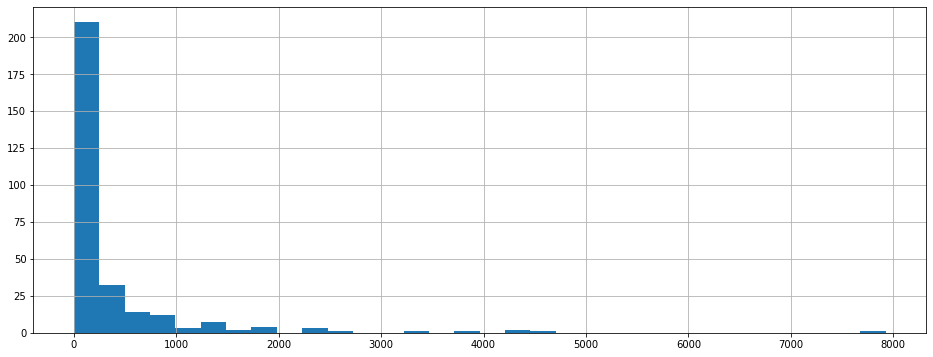

In [7]:
# pd.options.display.max_rows, pd.options.display.min_rows = 64, 16
X['author'].value_counts().hist(bins=32, figsize=(16,6))

In [8]:
vc = X['author'].value_counts()
cs = vc.cumsum() < vc.sum() * .67
authors = vc[cs]

# 33 authors account for 2/3rds of emails
print(len(authors))
authors[:8]

33


kay.mann           7925
vince.kaminski     4677
chris.germany      4426
jeff.dasovich      4240
sara.shackleton    3937
tana.jones         3285
kate.symes         2606
sally.beck         2457
Name: author, dtype: int64

In [9]:
# filter to most commonly occurring authors
mask = X['author'].apply(lambda x: x in authors.index)
X = X[mask]

In [10]:
# encode authors with numerical labels
LABEL_DICT = {}
for index, label in enumerate(authors.index):
    LABEL_DICT[label] = index
# LABEL_DICT

X = X.assign(label=X['author'].replace(LABEL_DICT))

### train/test split

In [11]:
# stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X.index.values, 
    X['label'].values, 
    test_size=0.15, 
    random_state=seed, 
    stratify=X['label'].values
)

In [12]:
X['data_type'] = np.nan * X.shape[0]
X.loc[X_train, 'data_type'] = 'train'
X.loc[X_test, 'data_type'] = 'test'

# X.groupby(['author', 'label', 'data_type']).count()

<AxesSubplot:>

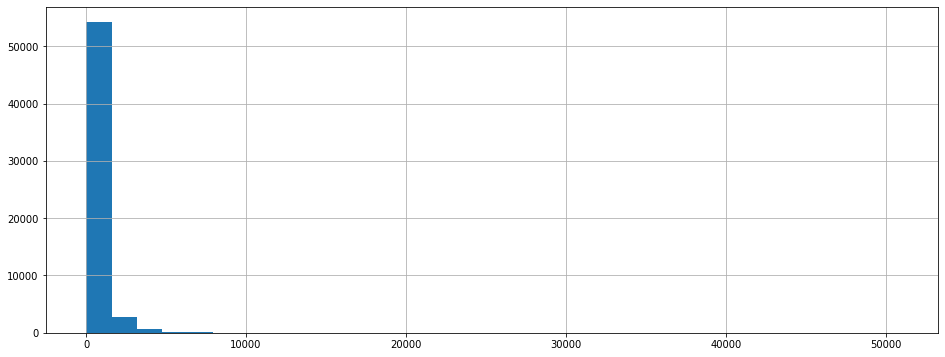

In [13]:
X[X['data_type']=='train']['body'].apply(len).hist(bins=32, figsize=(16,6))

{0.9: 1222, 0.95: 1869, 0.98: 3028, 0.99: 4101}


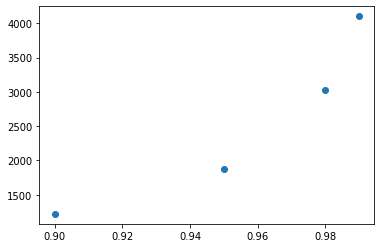

In [14]:
vc = X['body'].apply(len).value_counts().sort_index()
percents = [.9, .95, .98, .99]
cs = map(lambda x: vc.cumsum() < vc.sum() * x, percents)
lens = [vc[~i].index.min() for i in cs]
points = dict(zip(percents, lens))

print(points)
plt.scatter(percents, lens)

# 95% of emails are no longer than 1869 characters

In [15]:
max_len = points[0.95]

### tokenize

In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [18]:
# partial evaluation (curry) for setting default values
tokenizer_cur = curry(tokenizer.batch_encode_plus)(
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=max_len,
    truncation=True,
    return_tensors='pt'
)

In [19]:
n_train = 10000
mask_train = X['data_type']=='train'

encoded_data_train = tokenizer_cur(
    X[mask_train]['body'][:n_train].values
)

In [20]:
n_test = 1000
mask_test = X['data_type']=='test'

encoded_data_test = tokenizer_cur(
    X[mask_test]['body'][:n_test].values
)

In [21]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(X[mask_train]['label'][:n_train].values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(X[mask_test]['label'][:n_test].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

### bert

In [22]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(LABEL_DICT),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
batch_size = 3

dataloader_train = DataLoader(
    dataset_train, 
    sampler=RandomSampler(dataset_train), 
    batch_size=batch_size
)
dataloader_tet = DataLoader(
    dataset_test, 
    sampler=SequentialSampler(dataset_test), 
    batch_size=batch_size
)

In [24]:
epochs = 5

optimizer = AdamW(
    model.parameters(),
    lr=1e-5, 
    eps=1e-8
)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

In [25]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in LABEL_DICT.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])} / {len(y_true)}\n')

### training

In [26]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
def input_dict(batch):
    return {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2]
    }

In [104]:
def evaluate(dataloader_test):

    model.eval()
    
    loss_test_total = 0
    predictions, true_tests = [], []
    
    for batch in dataloader_test:

        batch = tuple(b.to(device) for b in batch)
        inputs = input_dict(batch)

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_test_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_tests.append(label_ids)
    
    loss_test_avg = loss_test_total / len(dataloader_test) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_tests = np.concatenate(true_tests, axis=0)
            
    return loss_test_avg, predictions, true_tests

In [105]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    progress_bar = tqdm(
        dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False
    )
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        inputs = input_dict(batch)    
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total / len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    test_loss, predictions, true_tests = evaluate(dataloader_test)
    test_f1 = f1_score_func(predictions, true_tests)
    tqdm.write(f'Test loss: {test_loss}')
    tqdm.write(f'F1 Score (Weighted): {test_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3334 [00:00<?, ?it/s]

NameError: name 'device' is not defined